# LSTM

##### LSTM是RNN的一种变种，在于RNN随着时间的推移，一些记忆会消失，于是在LSTM中，添加了遗忘门、输入门以及输出门来防止遗忘，其实遗忘的好坏是sigmoid函数来学习的

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [9]:
mnist = input_data.read_data_sets('/tmp/data/', one_hot=True)
INPUT = 28
HIDDEN = 128
OUTPUT = 10

INPUT += HIDDEN

ALPHA = 0.001
BATCH_NUM = 64

ITER_NUM = 1000
LOG_ITER = ITER_NUM // 10
PLOT_ITER = ITER_NUM // 200

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
def softmax(arr):
    c = np.clip(arr, -700, 700) # 防止溢出 
    e = np.exp(c)
    return e / np.sum(e, axis=1, keepdims=True)

# 交叉熵
def cross_entropy(out, label):
    entropy = label * np.log(out + 1e-6)
    return -np.sum(entropy, axis=1, keepdims=True)

def sigmoid(arr):
    c = np.clip(arr, -700, 700)
    return 1 / (1 + np.exp(-c))

def deriv_sigmoid(out):
    return out * (1 - out)

def tanh(arr):
    c = np.clip(arr, -350, 350)
    return 2 / (1 + np.exp(-2 * c)) - 1

def deriv_tanh(out):
    return 1 - np.square(out)

In [11]:
errors = []

wf = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wi = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wc = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wo = np.random.randn(INPUT, HIDDEN) / np.sqrt(INPUT / 2)
wy = np.random.randn(HIDDEN, OUTPUT) / np.sqrt(HIDDEN / 2)

bf = np.zeros(HIDDEN)
bi = np.zeros(HIDDEN)
bc = np.zeros(HIDDEN)
bo = np.zeros(HIDDEN)
by = np.zeros(OUTPUT)

dwf = np.zeros_like(wf)
dwi = np.zeros_like(wi)
dwc = np.zeros_like(wc)
dwo = np.zeros_like(wo)
dwy = np.zeros_like(wy)

dbf = np.zeros_like(bf)
dbi = np.zeros_like(bi)
dbc = np.zeros_like(bc)
dbo = np.zeros_like(bo)
dby = np.zeros_like(by)

![image.png](fig1.png)

In [12]:
def LSTM_Cell(input_val):
    batch_num = input_val.shape[1]
    
    caches = []
    states = []
    # 初始状态 c 和 h_prev都是为0
    states.append([np.zeros([batch_num, HIDDEN]), np.zeros([batch_num, HIDDEN])])
    
    for x in input_val:
        c_prev, h_prev = states[-1]
        x = np.column_stack([x, h_prev])
        hf = sigmoid(np.dot(x, wf) + bf)
        hi = sigmoid(np.dot(x, wi) + bi)
        ho = sigmoid(np.dot(x, wo) + bo)
        hc = tanh(np.dot(x, wc) + bc)
    
        c = hf * c_prev + hi * hc
        h = ho * tanh(c)
    
        states.append([c, h])
        caches.append([x, hf, hi, ho, hc])
        
    return caches, states

In [13]:
def predict(img):
    input_val = np.reshape(img, [28, 1, 28])
    
    caches, states = LSTM_Cell(input_val)
    c, h = states[-1]
    
    pred = softmax(np.dot(h, wy) + by)
    label = np.argmax(pred)
    
    return label

![image.png](fig2.png)

In [15]:
for i in range(ITER_NUM+1):
    X, Y = mnist.train.next_batch(BATCH_NUM)
    Xt = np.transpose(np.reshape(X, [-1, 28, 28]), [1, 0, 2])
        
    caches, states = LSTM_Cell(Xt)
    c, h = states[-1]
        
    out = np.dot(h, wy) + by
    pred = softmax(out)
    entropy = cross_entropy(pred, Y)
    
    # BPTT
    dout = pred - Y
    dwy = np.dot(h.T, dout)
    dby = np.sum(dout, axis=0)
    
    dc_next = np.zeros_like(c)
    dh_next = np.zeros_like(h)
    
    # 28为时间 通过28来反向传播
    for t in range(Xt.shape[0]):
        c, h = states[-t-1]
        c_prev, h_prev = states[-t-2]

        x, hf, hi, ho, hc = caches[-t-1]
        
        # 当前状态c的值
        tc = tanh(c)
        dh = np.dot(dout, wy.T) + dh_next
        
        
        # 根据前面的图 
        dc = dh * ho * deriv_tanh(tc)
        dc = dc + dc_next
        
        dho = dh * tc 
        dho = dho * deriv_sigmoid(ho)
        
        dhf = dc * c_prev 
        dhf = dhf * deriv_sigmoid(hf)
        
        dhi = dc * hc 
        dhi = dhi * deriv_sigmoid(hi)
        
        dhc = dc * hi 
        dhc = dhc * deriv_tanh(hc)
        
        dwf += np.dot(x.T, dhf)
        dbf += np.sum(dhf, axis=0)
        dXf = np.dot(dhf, wf.T)
        
        dwi += np.dot(x.T, dhi)
        dbi += np.sum(dhi, axis=0)
        dXi = np.dot(dhi, wi.T)
        
        dwo += np.dot(x.T, dho)
        dbo += np.sum(dho, axis=0)
        dXo = np.dot(dho, wo.T)
        
        dwc += np.dot(x.T, dhc)
        dbc += np.sum(dhc, axis=0)
        dXc = np.dot(dhc, wc.T)

        dX = dXf + dXi + dXo + dXc
        
        dc_next = hf * dc
        dh_next = dX[:, -HIDDEN:]
        
    # Update weights
    wf -= ALPHA * dwf
    wi -= ALPHA * dwi
    wc -= ALPHA * dwc
    wo -= ALPHA * dwo
    wy -= ALPHA * dwy
    
    bf -= ALPHA * dbf
    bi -= ALPHA * dbi
    bc -= ALPHA * dbc
    bo -= ALPHA * dbo
    by -= ALPHA * dby
    
    # 每次完成后初始化
    dwf = 0
    dwi = 0
    dwc = 0
    dwo = 0
    dwy = 0
    
    dbf = 0
    dbi = 0
    dbc = 0
    dbo = 0
    dby = 0
    
    # 打印输出日记
    if i % PLOT_ITER == 0:
        errors.append(np.sum(entropy))
    
    if i % LOG_ITER == 0:
        print('iter', i)
        print('entropy', np.sum(entropy))
        print('----------')

iter 0
entropy 147.382812207
----------
iter 100
entropy 111.459329837
----------
iter 200
entropy 41.666139336
----------
iter 300
entropy 30.0683686754
----------
iter 400
entropy 26.3604827937
----------
iter 500
entropy 27.5656288248
----------
iter 600
entropy 15.9428425878
----------
iter 700
entropy 10.5399803391
----------
iter 800
entropy 28.753544287
----------
iter 900
entropy 3.03384578892
----------
iter 1000
entropy 11.7717090141
----------


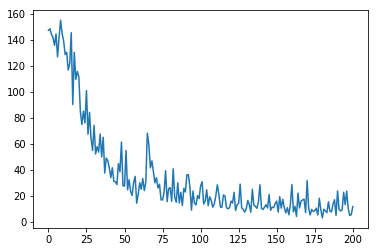

In [16]:
plt.plot(errors)

prediction : 4


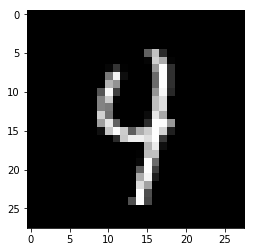

In [17]:
i = np.random.randint(55000)
img = mnist.train.images[i]
img = np.reshape(img, [28, 28])

pred = predict(img)
print('prediction :', pred)

plt.imshow(img, cmap='gray')

In [18]:
res = 0
for img,labels in zip(mnist.test.images,mnist.test.labels):
    pred = predict(img)
    res += (pred==labels.argmax())

In [19]:
res / mnist.test.num_examples

0.94869999999999999